# Download the Images Prepared in Google Earth Engine

In [ ]:
!mkdir Prichit
!wget  https://zenodo.org/records/12750779/files/Factors_prichit.tif?download=1  -O Prichit/Factors.tif
!wget  https://zenodo.org/records/12750779/files/GT_prichit.gpkg?download=1 -O Prichit/GT.gpkg

# Install necessary packages

In [ ]:
!pip install rasterio

# Import the libraries

In [1]:
import numpy as np
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio import features
from tqdm.notebook import tqdm

**Load the Enviromental Factors downloaded directory and check it for its properties as well as quality**

In [2]:
src = rasterio.open("Prichit/Factors.tif")
img = src.read()
img.shape

(12, 2011, 1243)

In [3]:
img_vis = img[1, :, :]

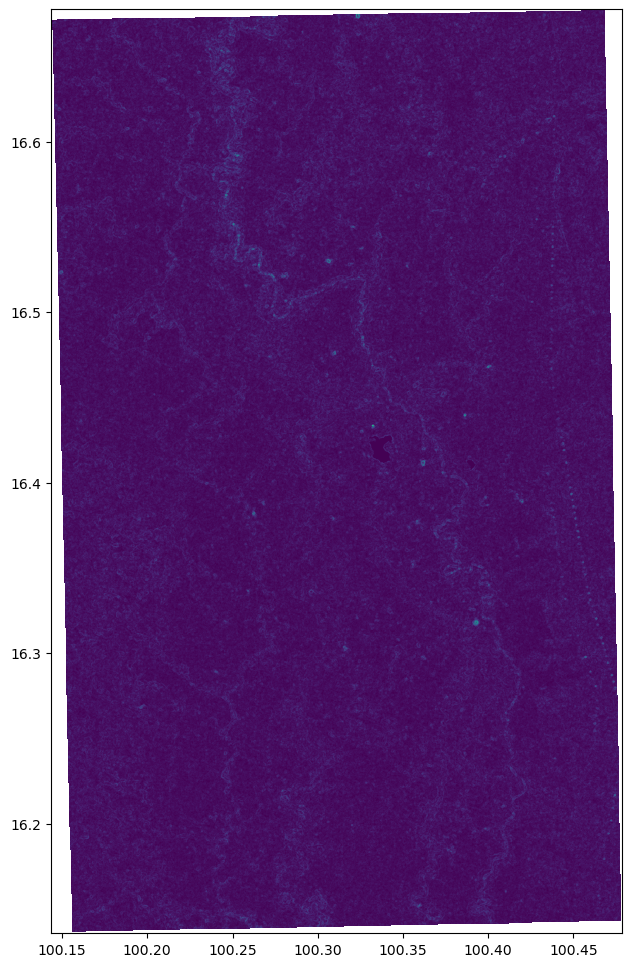

In [4]:
fig, ax = plt.subplots(1, figsize=(12, 12))
show(img_vis, transform=src.transform, ax=ax)
ax.ticklabel_format(useOffset=False, style="plain")

**Load Ground Truth Data**

In [5]:
GroundTruth = gpd.read_file("Prichit/GT.gpkg").to_crs(epsg=4326)

**Visualize it together with the enviromental factors**

<Axes: >

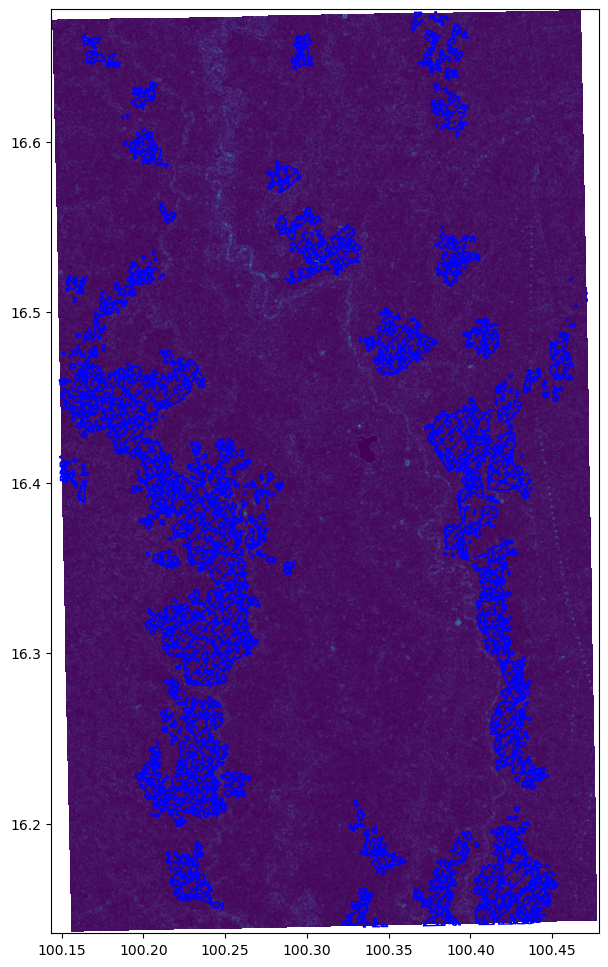

In [6]:
fig, ax = plt.subplots(1, figsize=(12, 12))
show(img_vis, transform=src.transform, ax=ax)
ax.ticklabel_format(useOffset=False, style="plain")
GroundTruth.plot(ax=ax, color="none", edgecolor="blue", hatch="//")

**This shows that our image and training dataset have same extent in most of the cases. Now, lets convert the ground truth into an image such that we can use it to train the model.**

In [7]:
shapes = ((geom, 1) for geom in GroundTruth.geometry)
raster_GT = features.rasterize(
    shapes=shapes, fill=0, out_shape=img[0].shape, transform=src.transform
)

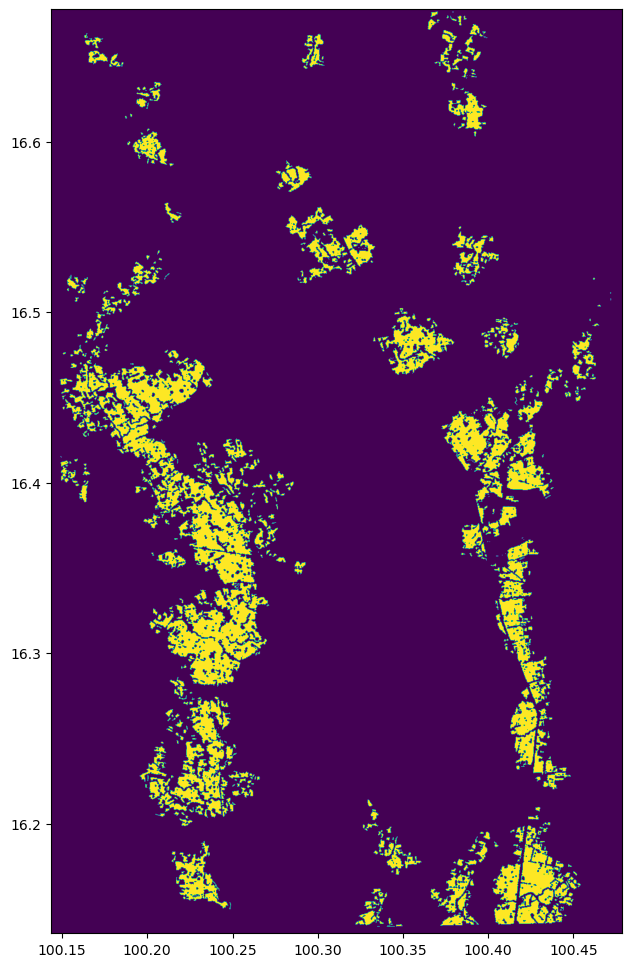

In [8]:
fig, ax = plt.subplots(1, figsize=(12, 12))
show(raster_GT, transform=src.transform, ax=ax)
ax.ticklabel_format(useOffset=False, style="plain")

**Now make them Xdata and Ydata**

In [9]:
XData = img.transpose((1, 2, 0))
YData = np.expand_dims(raster_GT, -1)

**Lets create small patches for mapping**

In [10]:
PATCHSIZE = 32
NBANDS = XData.shape[-1]

def gridwise_sample(ximg, yimg, patchsize):
    """Extract sample patches of size patchsize x patchsize from an image (imgarray) in a gridwise manner."""
    nrows, ncols, nbands = ximg.shape
    first = True
    for i in tqdm(range(int(nrows / patchsize))):
        for j in range(int(ncols / patchsize)):
            xpatch = ximg[
                i * patchsize : (i + 1) * patchsize,
                j * patchsize : (j + 1) * patchsize,
                :,
            ]
            ypatch = yimg[
                i * patchsize : (i + 1) * patchsize,
                j * patchsize : (j + 1) * patchsize,
                :,
            ]
            xpatch = np.expand_dims(xpatch, axis=0)
            ypatch = np.expand_dims(ypatch, axis=0)
            if not (np.any(np.isnan(xpatch)) or np.any(np.isnan(ypatch))):
                if first:
                    xpatches,ypatches = xpatch,ypatch
                    first = False
                else:
                    xpatches = np.concatenate((xpatches, xpatch), axis=0)
                    ypatches = np.concatenate((ypatches, ypatch), axis=0)
    return xpatches,ypatches


XPatches,YPatches = gridwise_sample(XData,YData, PATCHSIZE)

print("There are %i number of image patches" % (XPatches.shape[0]))

  0%|          | 0/62 [00:00<?, ?it/s]

There are 2011 number of image patches


**Let's Do some Sanity Check**

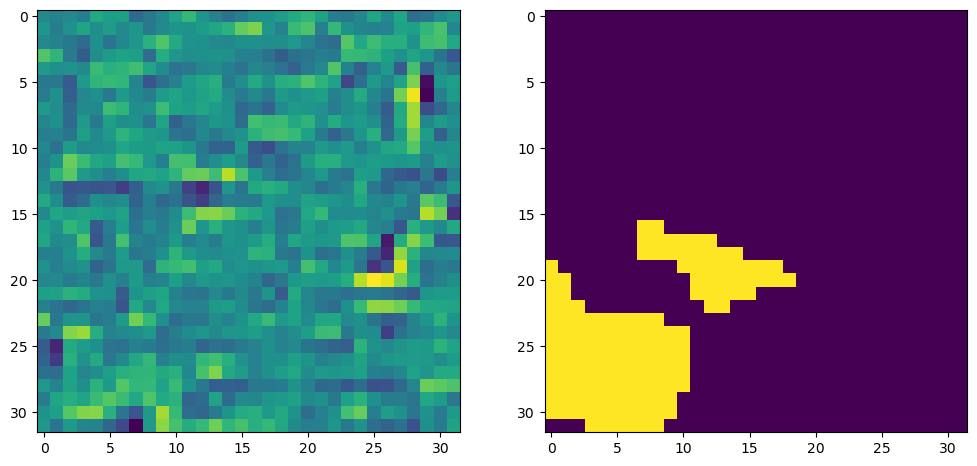

In [11]:
n = 155  # sample number
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(XPatches[n, :, :, 3])
ax[1].imshow(YPatches[n, :, :, 0])

ax[0].ticklabel_format(useOffset=False, style="plain")
ax[1].ticklabel_format(useOffset=False, style="plain")

**Save them into numpy array**

In [12]:
np.save("Prichit/XData.npy", XPatches)
np.save("Prichit/YData.npy", YPatches)